In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import pyvista as pv
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


/tmp/ipykernel_173848/2196458997.py:21: UserWarning: could not determine irispy package version; this indicates a broken installation
  import irispy.io


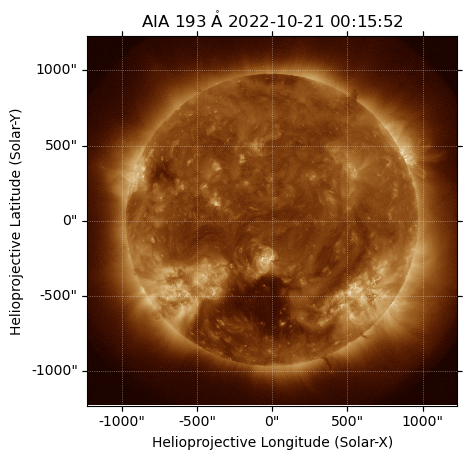

In [2]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221021/193/lvl15/aia.lev1_euv_12s.2022-10-21T001551Z.193.image.fits")
aia_193_map.plot()

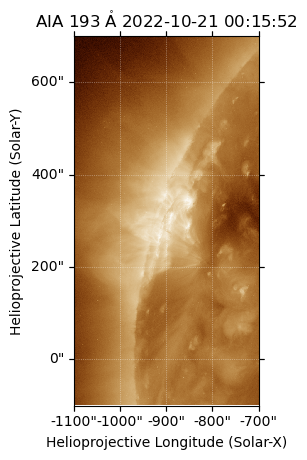

In [3]:
aia_193_map_crop = aia_193_map.submap(SkyCoord(-1100*u.arcsec,-100*u.arcsec,frame=aia_193_map.coordinate_frame),
                                        top_right=SkyCoord(-700*u.arcsec,700*u.arcsec,frame=aia_193_map.coordinate_frame))
aia_193_map_crop.plot()

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221020_234355.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


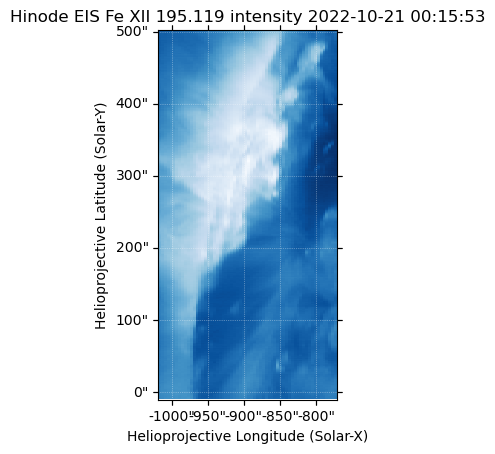

In [7]:
eis_195_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T2343/eis_20221020_234355.fe_12_195_119.1c-0.fit.h5")
eis_195_intmap = eis_195_fitres.get_map(component=0,measurement="intensity")
eis_195_intmap.meta["rsun_ref"] = aia_193_map.meta["rsun_ref"]
eis_195_intmap.plot()

In [9]:
aia_resample_nx = (aia_193_map_crop.scale.axis1 * aia_193_map_crop.dimensions.x) / eis_195_intmap.scale.axis1
aia_resample_ny = (aia_193_map_crop.scale.axis2 * aia_193_map_crop.dimensions.y) / eis_195_intmap.scale.axis2
aia_193_map_resample = aia_193_map_crop.resample(u.Quantity([aia_resample_nx, aia_resample_ny]))

In [10]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

In [13]:
eis_to_aia_Txshift, eis_to_aia_Tyshift = coalign_shift(aia_193_map_resample,eis_195_intmap)
print(eis_to_aia_Txshift)
print(eis_to_aia_Tyshift)

eis_195_velmap = eis_195_fitres.get_map(component=0,measurement="velocity")
eis_195_velmap.meta["rsun_ref"] = aia_193_map.meta["rsun_ref"]
eis_195_intmap_shift = eis_195_intmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)
eis_195_velmap_shift = eis_195_velmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)

2.89656 arcsec
-11.0916 arcsec
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


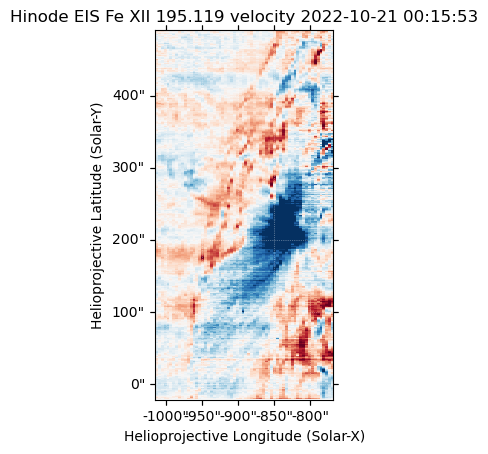

In [14]:
eis_195_velmap_shift.plot()

In [15]:
eis_195_intmap_shift.save("../../src/coalign_map/20221020/eis_195_intmap_shift.fits",overwrite=True)
eis_195_velmap_shift.save("../../src/coalign_map/20221020/eis_195_velmap_shift.fits",overwrite=True)